In [5]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [9]:
# To download and use the Washington DC image:
#hsi_data.download('WashingtonDC')
#fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# To download and use the polymers image:
hsi_data.download('MicroscenePolymers')
fname = hsi_data.get_fname('MicroscenePolymers')

Filename: C:/spectral_data\spectral_images\Microscene_Polymers/reflectance_image_polymers


In [10]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (852, 384, 452)
Shape of imList = (327168, 452)


# PART 2: Viewing a scatterplot of the hyperspectral image.

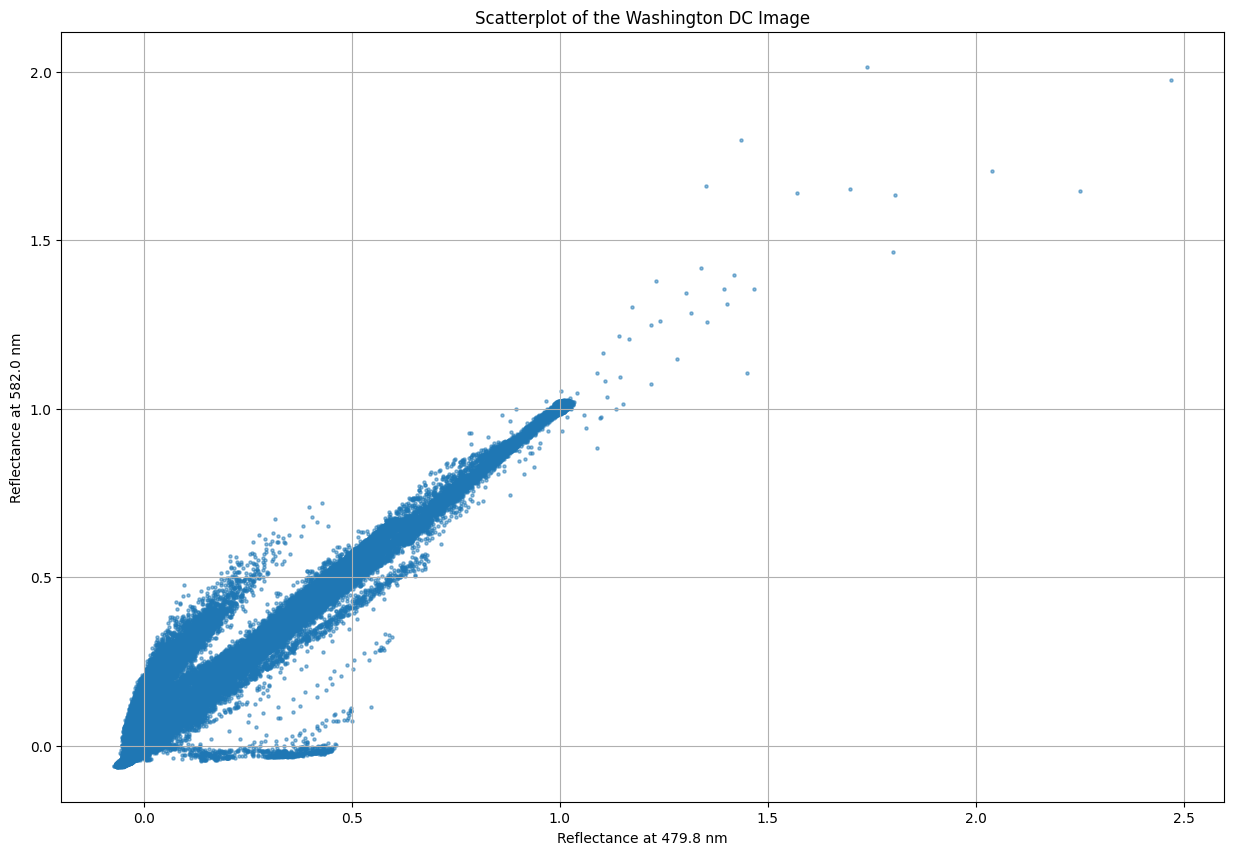

In [6]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, alpha=0.5);
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Clustering using K-Means

Documentation on K Means clustering using sklearn in Python: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

A discussion of 11 clustering algorithms with Python implementations is provided in: https://scikit-learn.org/stable/modules/clustering.html

In [7]:
from sklearn.cluster import KMeans
n_clusters = 5

# define the model
model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(imList)
# assign a cluster to each example
yhat = model.predict(imList)

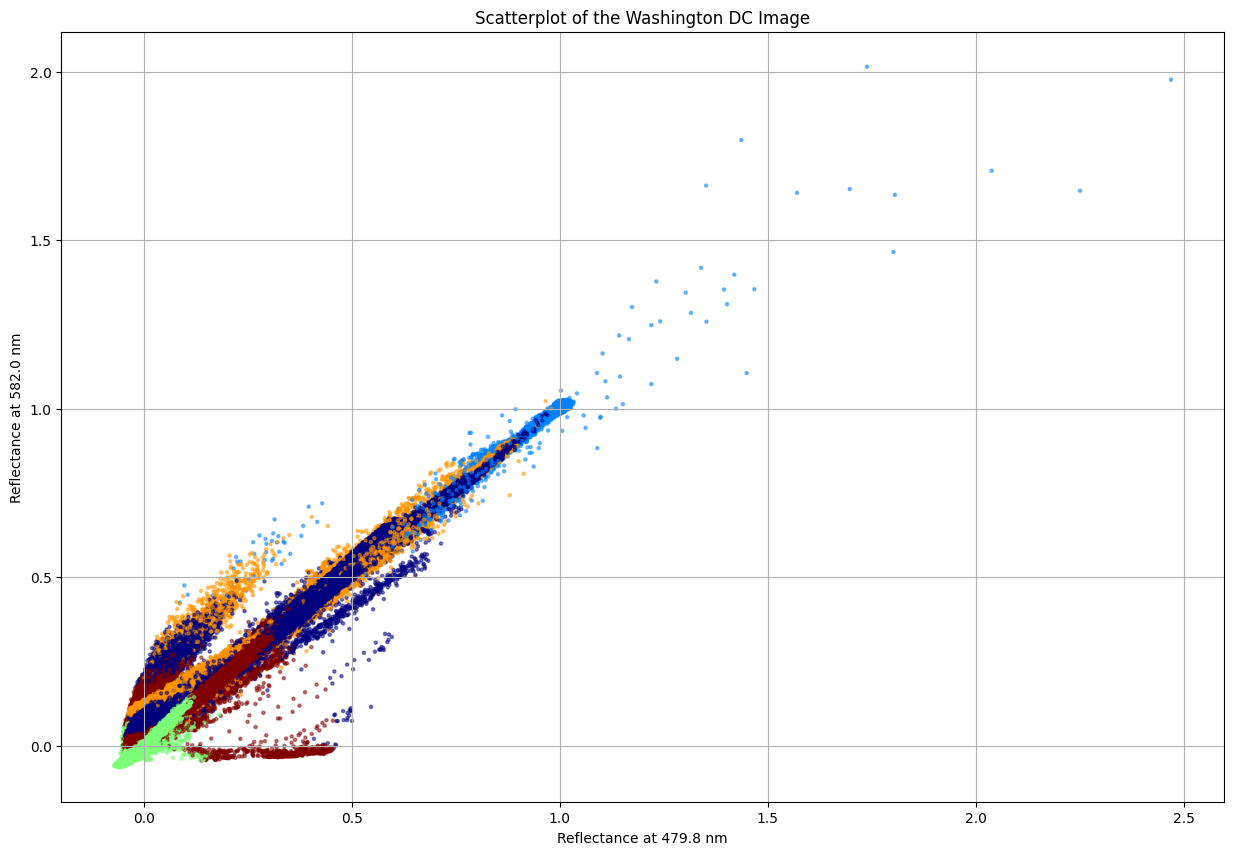

In [8]:
# Create a scatterplot of the data, colored by class
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, c=yhat, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

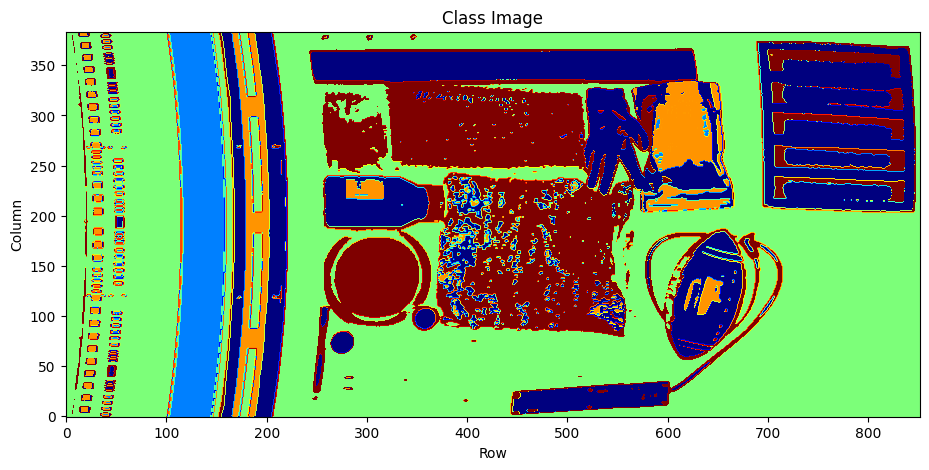

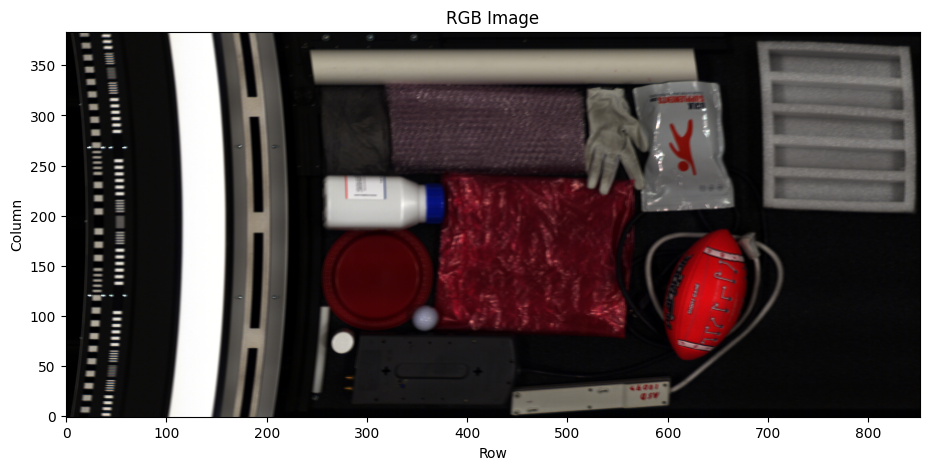

In [9]:
# Display the image, with each pixel colored by class
class_image = np.reshape(yhat, (im.nrows, im.ncols))

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(class_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Class Image')

sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

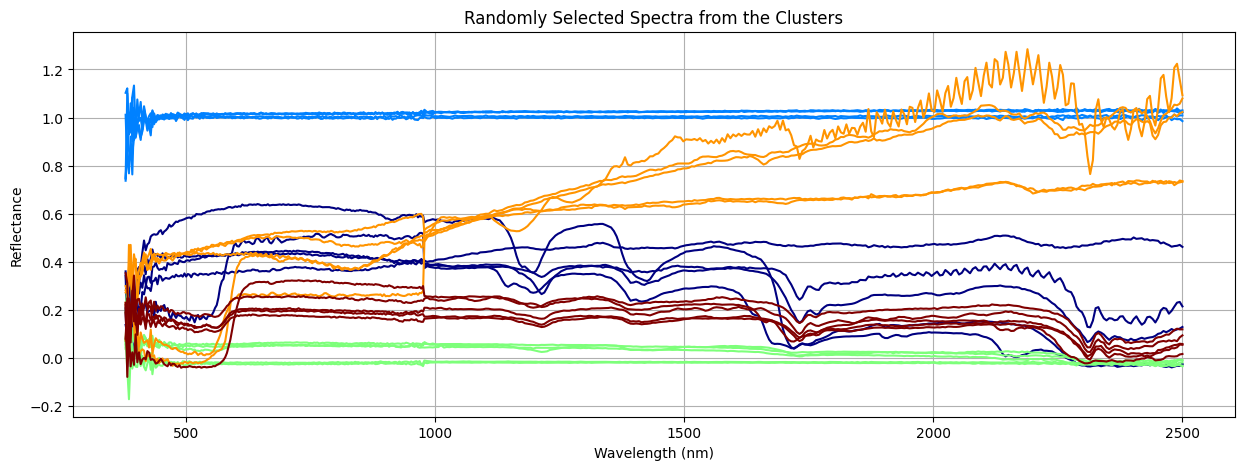

In [10]:
# Plot a few randomly selected spectra from each class
colors = plt.cm.jet(np.linspace(0,1,n_clusters)) # Create a list of colors to color the plots
N = 5 #number of spectra to plot for each class

class_labels = np.unique(yhat) # Get a list of the class labels

plt.figure(figsize=(15,5))
for lbl in class_labels:
    class_indices = np.where(yhat==lbl)[0] # get the set of indices for this class
    class_indices_subset = np.random.choice(class_indices, size=N) # get a random subset of the indices for spectra for this class
    for idx in class_indices_subset:
        plt.plot(wl, imList[idx,:], c=colors[lbl])

plt.grid(True)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Randomly Selected Spectra from the Clusters');

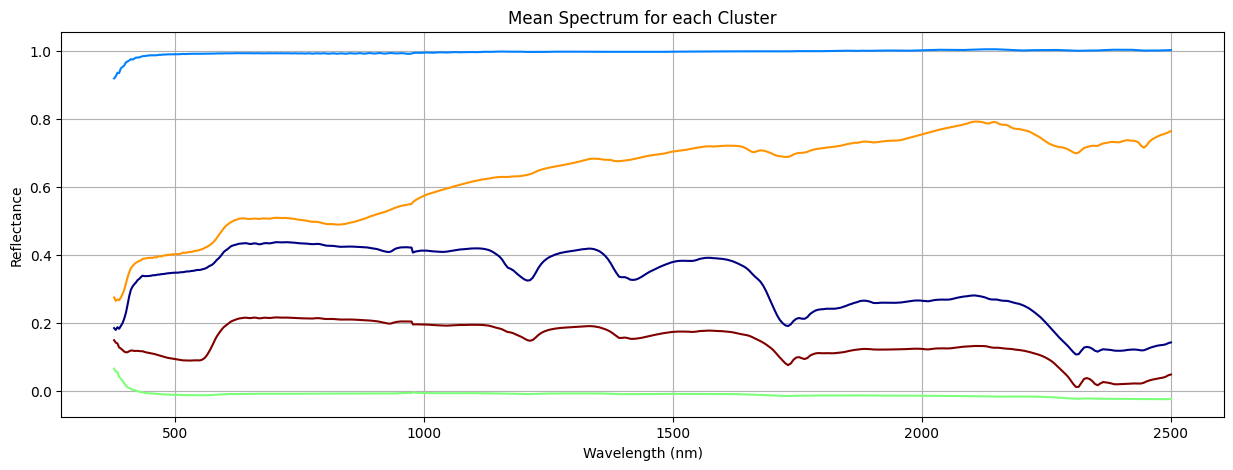

In [11]:
# Plot the mean of each class
colors = plt.cm.jet(np.linspace(0,1,n_clusters)) # Create a list of colors to color the plots

class_labels = np.unique(yhat) # Get a list of the class labels

plt.figure(figsize=(15,5))
for lbl in class_labels:
    class_indices = np.where(yhat==lbl)[0] # get the set of indices for this class
    class_mean = np.mean(imList[class_indices,:], axis=0) 
    plt.plot(wl, class_mean, c=colors[lbl])

plt.grid(True)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Mean Spectrum for each Cluster');

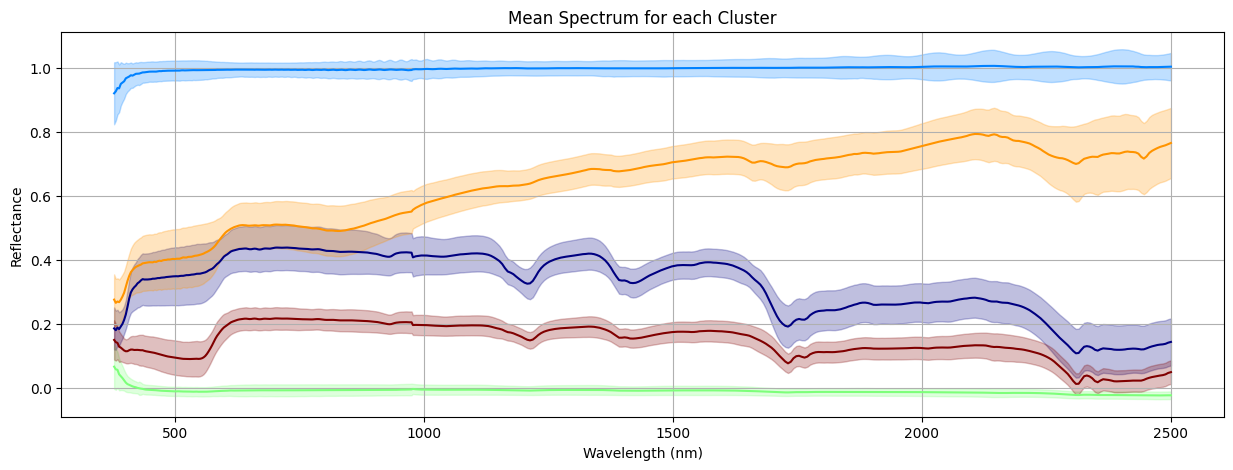

In [12]:
# Plot the mean of each class along with a 1-sigma range
colors = plt.cm.jet(np.linspace(0,1,n_clusters)) # Create a list of colors to color the plots

class_labels = np.unique(yhat) # Get a list of the class labels

plt.figure(figsize=(15,5))
for lbl in class_labels:
    class_indices = np.where(yhat==lbl)[0] # get the set of indices for this class
    class_std = np.std(imList[class_indices,:], axis=0) #
    class_mean = np.mean(imList[class_indices,:], axis=0) 
    plt.gca().fill_between(wl, class_mean+0.5*class_std, class_mean-0.5*class_std, color=colors[lbl], alpha=0.25)
    plt.plot(wl, class_mean, c=colors[lbl])

plt.grid(True)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Mean Spectrum for each Cluster');

# Expectation-Maximization Clustering

In [18]:
# Whiten the data, to compute clusters on first foew PCS
C = np.cov(imList.T)
m = np.mean(imList, axis=0)
# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
evals[evals<10**(-8)] = 10**(-8)
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)
imListDeMean = imList-m
imListW = np.matmul(W.T,imListDeMean.T).T 
imW = np.reshape(imListW, (im.nrows,im.ncols,im.nbands))

PC: 0, Pct. Variance = 0.0000
PC: 1, Pct. Variance = 0.9099
PC: 2, Pct. Variance = 0.9736
PC: 3, Pct. Variance = 0.9910
PC: 4, Pct. Variance = 0.9940
PC: 5, Pct. Variance = 0.9955
PC: 6, Pct. Variance = 0.9966
PC: 7, Pct. Variance = 0.9972
PC: 8, Pct. Variance = 0.9976
PC: 9, Pct. Variance = 0.9980
PC: 10, Pct. Variance = 0.9983
PC: 11, Pct. Variance = 0.9985
PC: 12, Pct. Variance = 0.9987
PC: 13, Pct. Variance = 0.9989
PC: 14, Pct. Variance = 0.9990
PC: 15, Pct. Variance = 0.9992
PC: 16, Pct. Variance = 0.9992
PC: 17, Pct. Variance = 0.9993
PC: 18, Pct. Variance = 0.9994
PC: 19, Pct. Variance = 0.9995


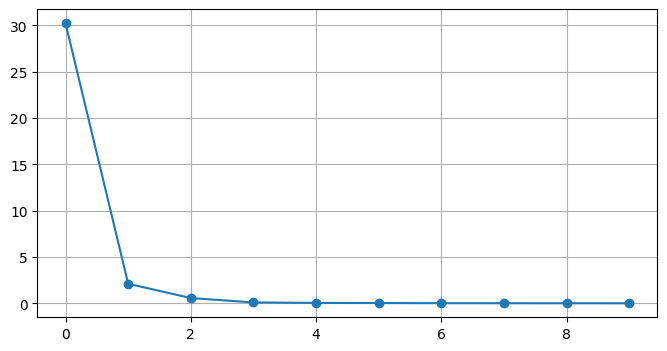

In [41]:
plt.figure(figsize=(8,4))
plt.plot(evals[:10], marker='o')
plt.grid(True)
for i in range(20):
    print(f'PC: {i}, Pct. Variance = {np.sum(evals[:i])/np.sum(evals):.4f}')

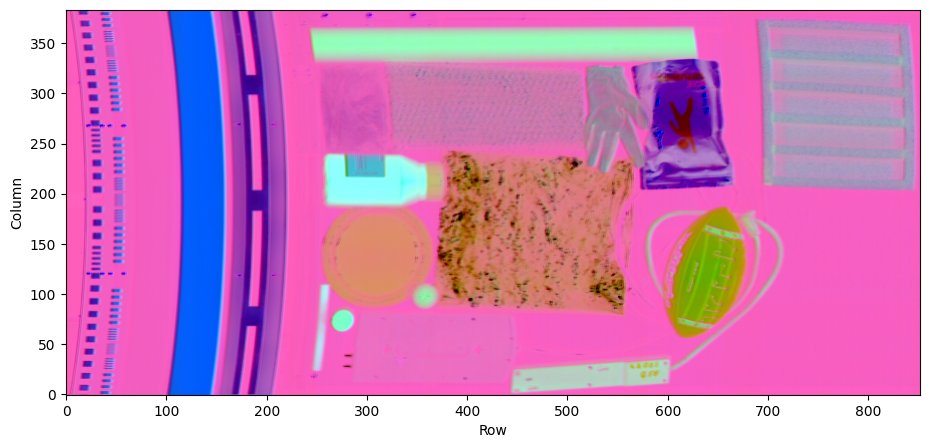

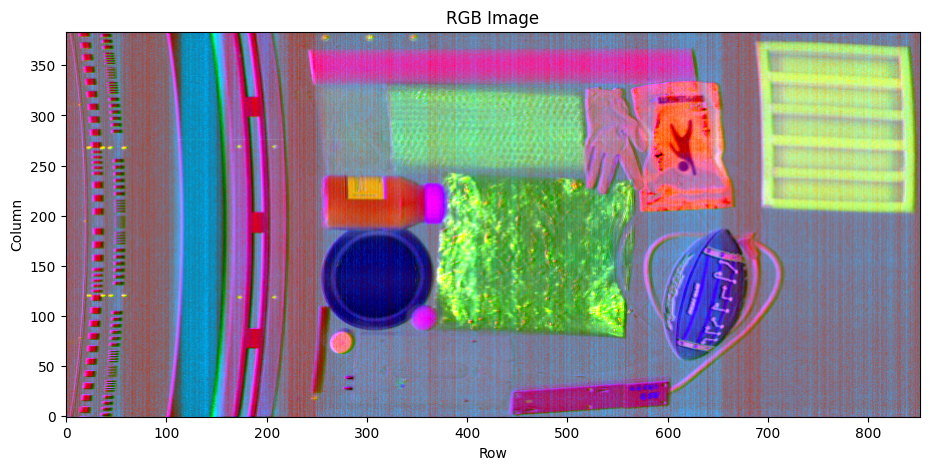

In [25]:
importlib.reload(sm2)
sm2.display_PCA(imW, PCs = [0,1,2], rotate=True)
sm2.display_PCA(imW, PCs = [3,4,5], rotate=True)
plt.title('RGB Image');

In [48]:
from sklearn.mixture import BayesianGaussianMixture

nPCs = 6
X = imListW[:,:nPCs]

n_clusters = 10

# define the model
print('Fitting the model...')
bgm = BayesianGaussianMixture(n_components=n_clusters, random_state=42).fit(X)
# assign a cluster to each example
print('Predicting calsses the model...')
yhat = bgm.predict(X)

Fitting the model...
Predicting calsses the model...


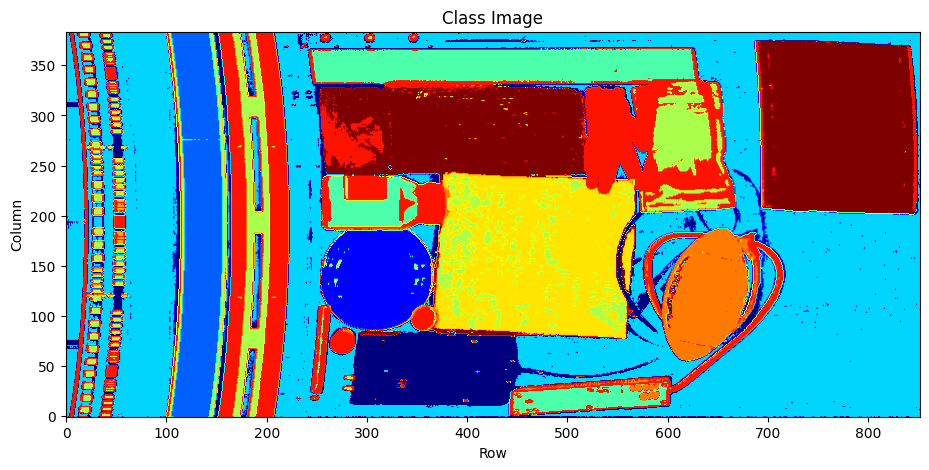

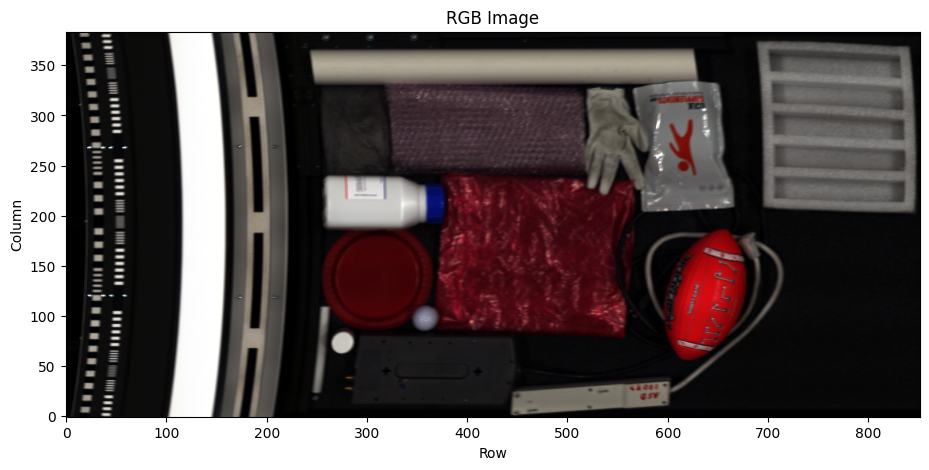

In [49]:
# Display the image, with each pixel colored by class
class_image = np.reshape(yhat, (im.nrows, im.ncols))

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(class_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Class Image')

sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

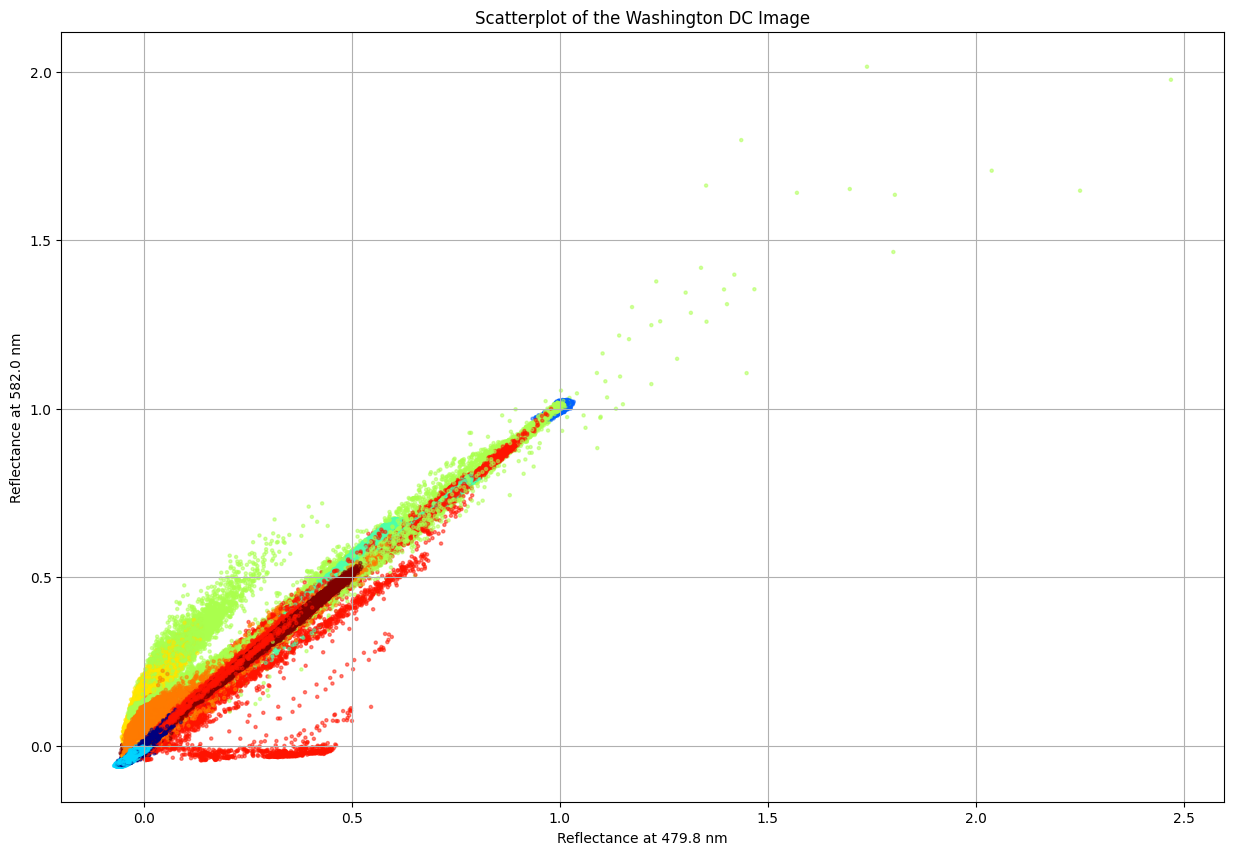

In [50]:
# Create a scatterplot of the data, colored by class
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, c=yhat, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

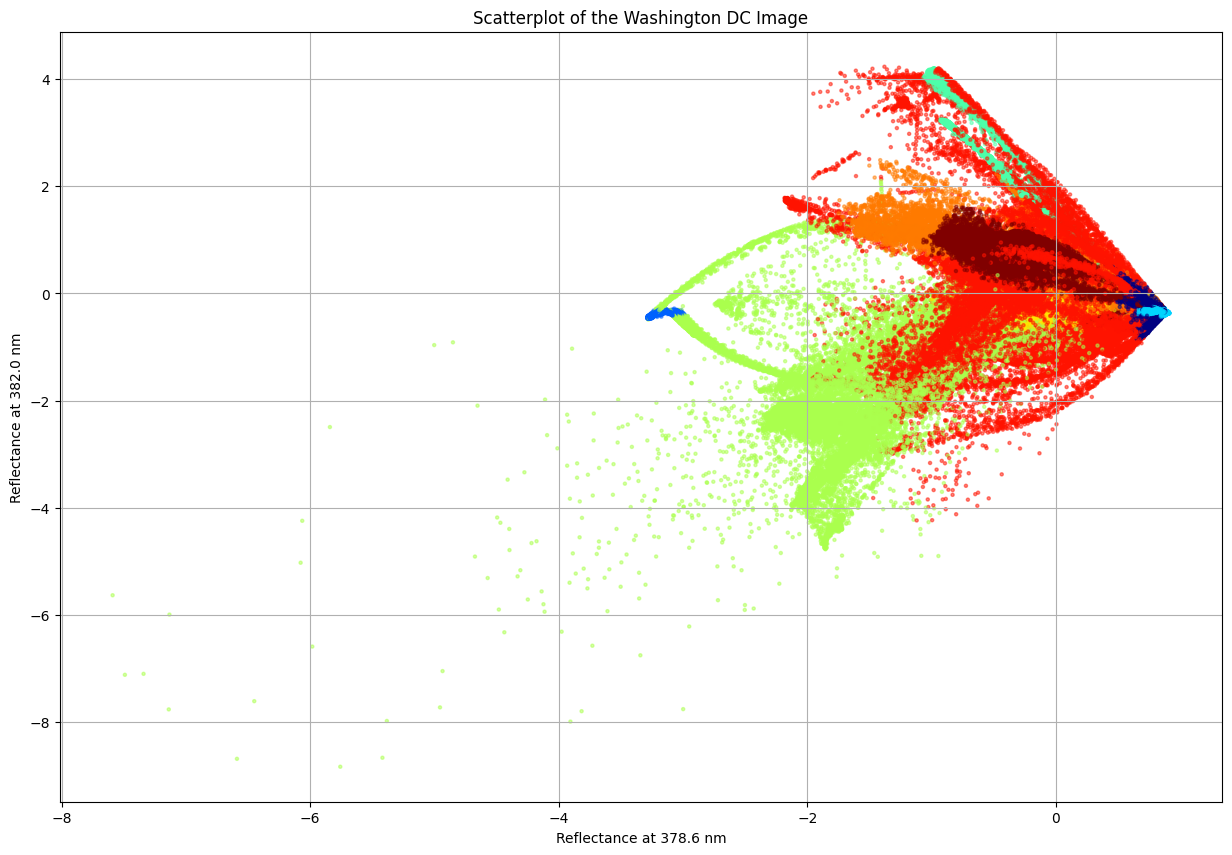

In [51]:
# Create a scatterplot of the data, colored by class
i1 = 0
i2 = 1

plt.figure(figsize=(15,10))
plt.scatter(imListW[:,i1], imListW[:,i2], s=5, c=yhat, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

In [54]:
nPCs = 6
X = imListW[:,:nPCs]

for n_clusters in range(1,12):

    # define the model
    bgm = BayesianGaussianMixture(n_components=n_clusters, random_state=42).fit(X)
    # assign a cluster to each example
    s = bgm.score(X)
    print(f'With n_clusters={n_clusters}:  mean likelihood = {np.exp(s)} and mean log-likelihood = {s}')

With n_clusters=1:  mean likelihood = 0.00020070661365741353 and mean log-likelihood = -8.513666349753182
With n_clusters=2:  mean likelihood = 0.019718703378563292 and mean log-likelihood = -3.926187683563532
With n_clusters=3:  mean likelihood = 0.04173108318870935 and mean log-likelihood = -3.1765090276412833
With n_clusters=4:  mean likelihood = 0.15397379466551267 and mean log-likelihood = -1.8709728555577887
With n_clusters=5:  mean likelihood = 0.3268948342584384 and mean log-likelihood = -1.1181167675841137
With n_clusters=6:  mean likelihood = 0.45346602199600555 and mean log-likelihood = -0.7908349361677195
With n_clusters=7:  mean likelihood = 0.5886045368766943 and mean log-likelihood = -0.5300007353009951
With n_clusters=8:  mean likelihood = 0.9607721549171087 and mean log-likelihood = -0.040017989780050126
With n_clusters=9:  mean likelihood = 1.1090344530776828 and mean log-likelihood = 0.10348977468249555
With n_clusters=10:  mean likelihood = 1.3476504625711125 and me

c:\Users\wb8by\Documents\GitHub\Machine-Learning-for-Spectral-Imaging\.venv\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


With n_clusters=11:  mean likelihood = 1.8408745934002695 and mean log-likelihood = 0.6102407811910852
